# Compare diferent approaches to compute A<sup>T</sup>A

### What we want to discuss here?

Let $\mathbf{A}$ be an $N \times M$ matrix. I would like to investigate different computational approaches to compute the product $\mathbf{A}^{\top}\mathbf{A}$. The simplest approach consists in computing the full $\mathbf{A}$ and use it to compute the matrix $\mathbf{A}^{\top}\mathbf{A}$. However, this approach requires to keep the full matrix $\mathbf{A}$ and the resulting matrix $\mathbf{A}^{\top}\mathbf{A}$ in memory. An alternative approach consists in compute $\mathbf{A}^{\top}\mathbf{A}$ iteratively. At each iteration, only a single columns of $\mathbf{A}$ is computed, so that the full $\mathbf{A}$ is never computed.

Let's take a look at this problem by using some math. Consider a $3 \times 2$ matrix $\mathbf{A}$ given by:

$$
\mathbf{A} =
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
a_{31} & a_{32}
\end{bmatrix} \: .
$$

By using the elements of $\mathbf{A}$, the matrix $\mathbf{A}^{\top}\mathbf{A}$ can be defined as follows:

$$
\mathbf{A}^{\top}\mathbf{A} = 
\begin{bmatrix}
(a_{11} \, a_{11} + a_{21} \, a_{21} + a_{31} \, a_{31}) &
(a_{11} \, a_{12} + a_{21} \, a_{22} + a_{31} \, a_{32}) \\
(a_{12} \, a_{11} + a_{22} \, a_{21} + a_{32} \, a_{31}) &
(a_{12} \, a_{12} + a_{22} \, a_{22} + a_{32} \, a_{32})
\end{bmatrix} \: .
$$

This matrix can be conveniently rewritten as the sum of three matrices as follows:

$$
\mathbf{A}^{\top}\mathbf{A} = 
\begin{bmatrix}
a_{11} \, a_{11} &
a_{11} \, a_{12} \\
a_{12} \, a_{11} &
a_{12} \, a_{12}
\end{bmatrix} +
\begin{bmatrix}
a_{21} \, a_{21} &
a_{21} \, a_{22} \\
a_{22} \, a_{21} &
a_{22} \, a_{22}
\end{bmatrix} +
\begin{bmatrix}
a_{31} \, a_{31} &
a_{31} \, a_{32} \\
a_{32} \, a_{31} &
a_{32} \, a_{32}
\end{bmatrix} \: .
$$

In this alternative definition of $\mathbf{A}^{\top}\mathbf{A}$, we can see that the each term depends only on the elements of a specific line of $\mathbf{A}$. Additionaly, each term represents an [outer product](https://en.wikipedia.org/wiki/Outer_product) of a specific line of $\mathbf{A}$.

The main message here is: $\mathbf{A}^{\top}\mathbf{A}$ can be computed iteratively, by using a single line of $\mathbf{A}$ at each iteration.

This notebook present four different approaches to compute the matrix $\mathbf{A}^{\top}\mathbf{A}$. The functions implementing these approaches are in the file `compute_ATA.py`. To analyse the performence of each approach, I have used the magic commands `%%timeit`, `%%memit`, `%memit` and `%lprun`. References to understand how these commands work are the [Profiling and Timing Code](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html), written by Jake VanderPlas, and the [Trying to understand python memory profiler](https://stackoverflow.com/questions/45318536/trying-to-understand-python-memory-profiler), posted in Stack Overflow.

### Import the required stuff

In [1]:
import numpy as np

# wrappers for BLAS routines
import scipy.linalg.blas as bla

# needed to use the line-by-line profiler %lprun
%load_ext line_profiler

# needed to use the memory profiler %%memit
%load_ext memory_profiler

In [2]:
import matplotlib.pyplot as plt

In [3]:
# functions to be analyzed
import compute_ATA as ata

### Auxiliary variables

In [4]:
# functions names
labels = ['compute_A', 'compute_ATA_numpy', 
          'compute_ATA_blas_dger', 'compute_ATA_blas_dsyr']

# average execution time
average_times = []

# standard deviation of the execution time 
stdev_times = []

# memory use
memory = []

In [5]:
# order of the square matrix A
N = 300

In [6]:
# Print the name of all variables
%who

N	 ata	 average_times	 bla	 labels	 memory	 np	 plt	 stdev_times	 



## Profiling the functions

#### Compute the full A and then the matrix A<sup>T</sup>A (Simplest approach)

In [7]:
%%timeit -n 10 -r 10 -o
A = ata.compute_A(N)
ATA1 = np.dot(A.T, A)

14 ms ± 1.23 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 14 ms ± 1.23 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [8]:
average_times.append(_.average)
stdev_times.append(_.stdev)

In [9]:
%memit -o

peak memory: 94.41 MiB, increment: 0.11 MiB


<MemitResult : peak memory: 94.41 MiB, increment: 0.11 MiB>

In [10]:
start_memory = _.mem_usage[0]

In [11]:
%%memit -r 10 -o
A = ata.compute_A(N)
ATA1 = np.dot(A.T, A)

peak memory: 95.16 MiB, increment: 0.48 MiB


<MemitResult : peak memory: 95.16 MiB, increment: 0.48 MiB>

In [12]:
memory.append(_.mem_usage[0] - start_memory)

In [13]:
# Print the name of all variables
%who

A	 ATA1	 N	 ata	 average_times	 bla	 labels	 memory	 np	 
plt	 start_memory	 stdev_times	 


#### Compute a single column of A and use `numpy.outer` to iteratively update the matrix A<sup>T</sup>A

In [14]:
%%timeit -n 10 -r 10 -o
ATA2 = ata.compute_ATA_numpy_outer(N)

76.4 ms ± 732 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 76.4 ms ± 732 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [15]:
average_times.append(_.average)
stdev_times.append(_.stdev)

In [16]:
%memit -o

peak memory: 95.86 MiB, increment: 0.02 MiB


<MemitResult : peak memory: 95.86 MiB, increment: 0.02 MiB>

In [17]:
start_memory = _.mem_usage[0]

In [18]:
%%memit -r 10 -o
ATA2 = ata.compute_ATA_numpy_outer(N)

peak memory: 95.86 MiB, increment: 0.00 MiB


<MemitResult : peak memory: 95.86 MiB, increment: 0.00 MiB>

In [19]:
memory.append(_.mem_usage[0] - start_memory)

In [20]:
%lprun -T lprun_numpy_outer -f ata.compute_ATA_numpy_outer ata.compute_ATA_numpy_outer(N)


*** Profile printout saved to text file 'lprun_numpy_outer'. 


In [21]:
# Print the name of all variables
%who

A	 ATA1	 ATA2	 N	 ata	 average_times	 bla	 labels	 memory	 
np	 plt	 start_memory	 stdev_times	 


#### Compute a single column of A and use `scipy.linalg.dger` to iteratively update the matrix A<sup>T</sup>A

In [22]:
%%timeit -n 10 -r 10 -o
ATA3 = ata.compute_ATA_blas_dger(N)

20.3 ms ± 1.13 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 20.3 ms ± 1.13 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [23]:
average_times.append(_.average)
stdev_times.append(_.stdev)

In [24]:
%memit -o

peak memory: 96.74 MiB, increment: 0.00 MiB


<MemitResult : peak memory: 96.74 MiB, increment: 0.00 MiB>

In [25]:
start_memory = _.mem_usage[0]

In [26]:
%%memit -r 10 -o
ATA3 = ata.compute_ATA_blas_dger(N)

peak memory: 96.80 MiB, increment: 0.06 MiB


<MemitResult : peak memory: 96.80 MiB, increment: 0.06 MiB>

In [27]:
#memory.append(_.baseline)
memory.append(_.mem_usage[0] - start_memory)

In [28]:
%lprun -T lprun_blas_dger -f ata.compute_ATA_blas_dger ata.compute_ATA_blas_dger(N)


*** Profile printout saved to text file 'lprun_blas_dger'. 


In [29]:
# Print the name of all variables
%who

A	 ATA1	 ATA2	 ATA3	 N	 ata	 average_times	 bla	 labels	 
memory	 np	 plt	 start_memory	 stdev_times	 


#### Compute a single column of A and use `scipy.linalg.dsyr` to iteratively update the matrix A<sup>T</sup>A

Take a look at the notebook `scipy-linalg-blas-examples.ipynb` to undertand how the routine `scipy.linalg.dsyr` works.

In [30]:
%%timeit -n 10 -r 10 -o
ATA4 = ata.compute_ATA_blas_dsyr(N)

22.4 ms ± 940 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 22.4 ms ± 940 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [31]:
average_times.append(_.average)
stdev_times.append(_.stdev)

In [32]:
%memit -o

peak memory: 97.56 MiB, increment: 0.00 MiB


<MemitResult : peak memory: 97.56 MiB, increment: 0.00 MiB>

In [33]:
start_memory = _.mem_usage[0]

In [34]:
%%memit -r 10 -o
ATA4 = ata.compute_ATA_blas_dsyr(N)

peak memory: 97.61 MiB, increment: 0.00 MiB


<MemitResult : peak memory: 97.61 MiB, increment: 0.00 MiB>

In [35]:
#memory.append(_.baseline)
memory.append(_.mem_usage[0] - start_memory)

In [36]:
%lprun -T lprun_blas_dsyr -f ata.compute_ATA_blas_dsyr ata.compute_ATA_blas_dsyr(N)


*** Profile printout saved to text file 'lprun_blas_dsyr'. 


In [37]:
# Print the name of all variables
%who

A	 ATA1	 ATA2	 ATA3	 ATA4	 N	 ata	 average_times	 bla	 
labels	 memory	 np	 plt	 start_memory	 stdev_times	 


### Compare the line-by-line profiling of each function (Simplest approach not included)

In [38]:
%cat 'lprun_numpy_outer'

Timer unit: 1e-06 s

Total time: 0.091116 s
File: /home/vanderlei/Documents/Calculo_numerico/code/compute_ATA.py
Function: compute_ATA_numpy_outer at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                           def compute_ATA_numpy_outer(N):
    25                                               '''
    26                                               Compute ATA by using the numpy.outer.
    27                                               '''
    28         1        256.0    256.0      0.3      ATA = np.zeros((N,N))
    29       301        366.0      1.2      0.4      for i in range(N):
    30       300      19855.0     66.2     21.8          ai = compute_v(N)
    31                                                   # I do not understand the difference between
    32                                                   # np.multiply.outer and np.outer
    33                                                   # ATA += np.multiply.

In [39]:
%cat 'lprun_blas_dger'

Timer unit: 1e-06 s

Total time: 0.035632 s
File: /home/vanderlei/Documents/Calculo_numerico/code/compute_ATA.py
Function: compute_ATA_blas_dger at line 38

Line #      Hits         Time  Per Hit   % Time  Line Contents
    38                                           def compute_ATA_blas_dger(N):
    39                                               '''
    40                                               Compute ATA by using the scipy wrraper for BLAS dger.
    41                                               '''
    42         1         81.0     81.0      0.2      ATA = np.zeros((N,N))
    43       301        490.0      1.6      1.4      for i in range(N):
    44       300      26214.0     87.4     73.6          ai = compute_v(N)
    45       300       8847.0     29.5     24.8          ATA = bla.dger(alpha=1, x=ai, y=ai, a=ATA, overwrite_a=1)
    46         1          0.0      0.0      0.0      return ATA

In [40]:
%cat 'lprun_blas_dsyr'

Timer unit: 1e-06 s

Total time: 0.032427 s
File: /home/vanderlei/Documents/Calculo_numerico/code/compute_ATA.py
Function: compute_ATA_blas_dsyr at line 49

Line #      Hits         Time  Per Hit   % Time  Line Contents
    49                                           def compute_ATA_blas_dsyr(N):
    50                                               '''
    51                                               Compute only the lower or upper part of ATA
    52                                               by using the scipy wrraper for BLAS dsyr.
    53                                               '''
    54         1        109.0    109.0      0.3      ATA = np.zeros((N,N))
    55       301        342.0      1.1      1.1      for i in range(N):
    56       300      21464.0     71.5     66.2          ai = compute_v(N)
    57       300      10511.0     35.0     32.4          ATA = bla.dsyr(alpha=1, x=ai, lower=1, n=N, a=ATA, overwrite_a=1)
    58         1          1.0      1.0      0.0   

### Plot the results

In [41]:
# transform values from s to ms
average_times = np.array(average_times)*1000
stdev_times = np.array(stdev_times)*1000

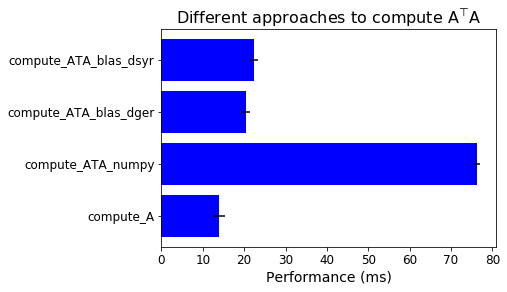

In [42]:
plt.figure()

plt.title('Different approaches to compute A$^{\\top}$A', fontsize=16)
plt.barh(labels, average_times, xerr=stdev_times, align='center',
         color='blue', ecolor='black')
plt.xlabel('Performance (ms)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

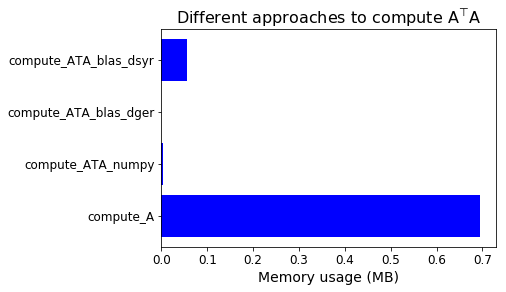

In [43]:
plt.figure()

plt.title('Different approaches to compute A$^{\\top}$A', fontsize=16)
plt.barh(labels, memory, align='center',
         color='blue', ecolor='black')
plt.xlabel('Memory usage (MB)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

The results suggest that the simplest approach is faster, but uses more memory. This "memory excess" may be due to the matrix A. In the simplest approach, the matrix A<sup>T</sup>A is computed by using the full matrix A. In the other three approaches, A<sup>T</sup>A is computed iteratively. At each iteration, only a single column of A is computed, so that the full matrix A is never computed.

### Try to compare the results by removing the memory required to compute the full A in the Simplest approach

In [44]:
%memit -o

peak memory: 103.11 MiB, increment: 0.02 MiB


<MemitResult : peak memory: 103.11 MiB, increment: 0.02 MiB>

In [45]:
start_memory = _.mem_usage[0]

In [46]:
%%memit -r 10 -o
A = ata.compute_A(N)

peak memory: 104.79 MiB, increment: 1.68 MiB


<MemitResult : peak memory: 104.79 MiB, increment: 1.68 MiB>

In [47]:
memory_to_store_A = _.mem_usage[0] - start_memory

In [48]:
print (memory_to_store_A)

1.6796875


In [49]:
memory[0] -= memory_to_store_A

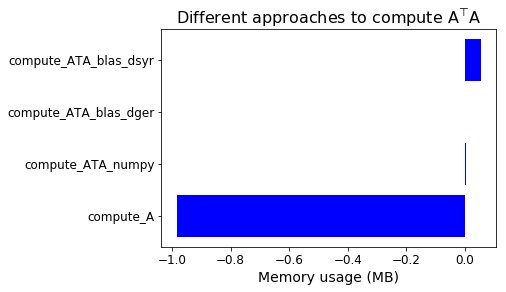

In [50]:
plt.figure()

plt.title('Different approaches to compute A$^{\\top}$A', fontsize=16)
plt.barh(labels, memory, align='center',
         color='blue', ecolor='black')
plt.xlabel('Memory usage (MB)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

**Note 1**: I am not convinced that the memory used to compute A was really removed from the previous results. This result seems to be very strange to me.

**Note 2**: Try to run this notebook by using different values for `N`. The results can be very different.